# Building Machine Learning Models and their selections

#### Best Model Results:


       1) XGBOOST
          Sensitivity : 0.8547
          Specificity : 0.9097
          ROC_AUC     : 0.9521

#          
       2) RANDOM FOREST CLASSIFIER
          Sensitivity : 0.8467
          Specificity : 0.9175
          ROC_AUC     : 0.9534

Stockout predicitons by predictive modeling is quite challenging since we are trying to solve Imbalanced Class problems. Hence High Sensitivity (Recall) for OOS class is desired. There will always be a tradeoff between Precision and Recall. Although Specificity values must also be optimum.

In [2]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
import pickle

from sklearn.naive_bayes import BernoulliNB,GaussianNB,BaseDiscreteNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [3]:
dataset = pickle.load(open("All data.pkl","rb"))

In [4]:
dataset.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [6]:
cols = ['national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 
       'sales_1_month', 'sales_3_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
        'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']

In [7]:
dataset = dataset[cols]

Removing the outliers as observed in the AutoEncoder Analysis

In [8]:
inlier_ids = pd.read_csv('inlier_ids.csv')
inlier_ids['id'] = inlier_ids['id']-1

In [9]:
inlier_ids.tail(10)

,id
1915926,1915944
1915927,1915945
1915928,1915946
1915929,1915947
1915930,1915948
1915931,1915949
1915932,1915950
1915933,1915951
1915934,1915952
1915935,1915953


In [10]:
print("dataset shape: ",dataset.shape)
print("inlier shape: ",inlier_ids.shape)

dataset shape:  (1929935, 17)
inlier shape:  (1915936, 1)


In [11]:
dataset = dataset.reset_index()
dataset = dataset.rename(columns={'index':'id'})
dataset = pd.merge(dataset,inlier_ids,on='id')
dataset.drop('id',axis=1,inplace=True)

In [12]:
dataset.shape

(1915936, 17)

In [13]:
train_df = dataset.copy()

In [14]:
train_df['went_on_backorder'].value_counts()

0    1902086
1      13850
Name: went_on_backorder, dtype: int64

In [15]:
continuous_var = ['national_inv','lead_time','in_transit_qty','forecast_3_month','sales_1_month',
           'sales_3_month','min_bank','pieces_past_due','perf_6_month_avg','local_bo_qty']

categorical_var = ['potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy',
            'rev_stop','went_on_backorder']
categorical_pred = ['potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy',
            'rev_stop']

Downsampling the dataset in 3:1 class ratio for understanding model behaviour

In [16]:

number_OOS  = len(train_df[train_df['went_on_backorder']==1])
OOS_indices = np.array(train_df[train_df['went_on_backorder']==1].index)
Normal_indices = np.array(train_df[train_df['went_on_backorder']==0].index)
random_normal_indices = np.array(np.random.choice(Normal_indices,3*number_OOS,replace=True))
under_sample_indices = np.concatenate([random_normal_indices,OOS_indices])
under_sample_train_df = train_df.loc[under_sample_indices,:]

#### Functions on Modeling

In [17]:
#Functions for modeling
def scale(X_train, X_test,c_var):
    std = StandardScaler()
    std.fit(X_train[c_var])
    pickle.dump(std, open("scaler.pkl","wb"))
    X_train[c_var] = std.transform(X_train[c_var])
    X_test[c_var] = std.transform(X_test[c_var])
    
    return X_train, X_test

In [18]:
y = under_sample_train_df['went_on_backorder']
X = under_sample_train_df.drop('went_on_backorder',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=41)
X_tr,X_te  = scale(X_train,X_test,continuous_var)

C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

 Scoring Metrics given Confusion Matrix for Out of Stock Class

In [17]:
def precision(matrix):
    if (matrix[1][1]+matrix[0][1]) == 0:
        return -1
    return matrix[1][1]/(matrix[1][1]+matrix[0][1])

def recall(matrix):
    if (matrix[1][1]+matrix[1][0]) == 0:
        return -1
    return matrix[1][1]/(matrix[1][1]+matrix[1][0])

def minScore(matrix):
    return min(precision(matrix),recall(matrix))

In [256]:
def print_heatmap(confusion):
    plt.figure(dpi=100)
    ax =sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['InStock','Out of Stock'])
    ax.yaxis.set_ticklabels(['InStock','Out of Stock']);
    
    

In [77]:
logit = LogisticRegression(C=10.5)
logit.fit(X_tr, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_te, y_test)))


The score for logistic regression is
Training:  75.15%
Test set:  75.23%


C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Recall for OOS class: 0.05720988991156831


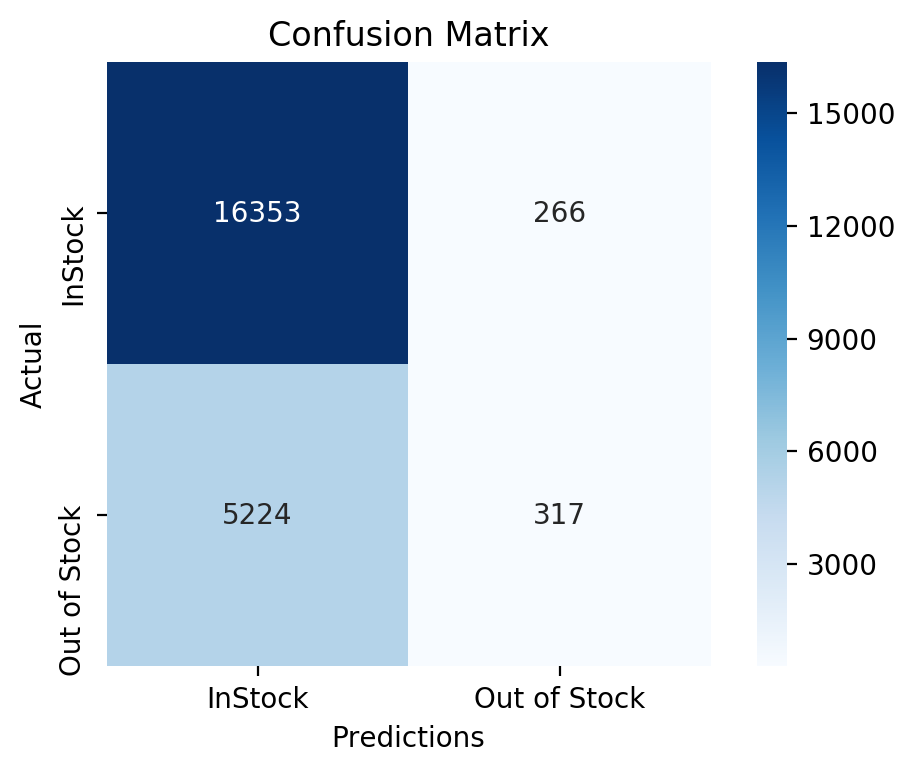

In [78]:
logit_confusion = confusion_matrix(y_test, logit.predict(X_te))
print_heatmap(logit_confusion)
print("Recall for OOS class:",recall(logit_confusion))

As we see a lot of cases of OOS are being neglected, Hence High False Negative and Less Recall values take place. This is the major problem of Imbalanced Class Problems

In [79]:
nb = BernoulliNB(alpha=0.5)
nb.fit(X_tr, y_train)
print("The score for Naive Bayes is")
print("Training: {:6.2f}%".format(100*nb.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*nb.score(X_te, y_test)))

The score for Naive Bayes is
Training:  77.25%
Test set:  77.28%


Recall for OOS class: 0.14311496119833966


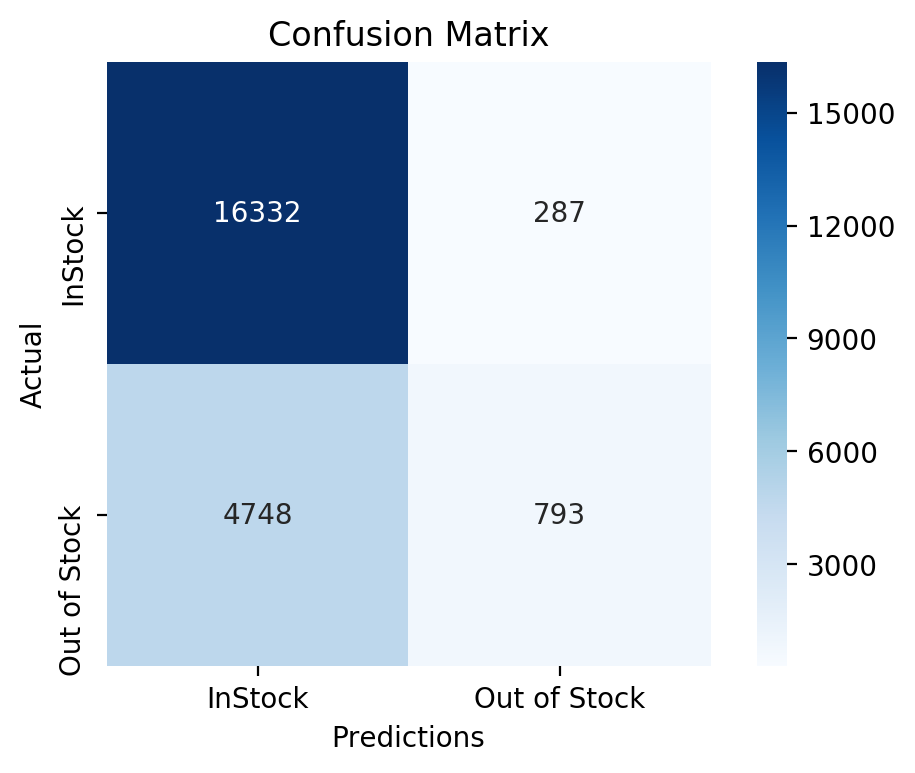

In [80]:
nb_confusion = confusion_matrix(y_test, nb.predict(X_te))
print_heatmap(nb_confusion)
print("Recall for OOS class:",recall(nb_confusion))

Some Improvement in detecting OOS in case of Bernoulli's Naive Bayes, Although results are not commendable.

In [133]:
gb = GaussianNB(var_smoothing=0.1510513)
gb.fit(X_tr, y_train)
print("The score for Gaussian Naive Bayes is")
print("Training: {:6.2f}%".format(100*gb.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*gb.score(X_te, y_test)))

The score for Gaussian Naive Bayes is
Training:  68.55%
Test set:  68.02%


Recall for OOS class: 0.47843349575888827


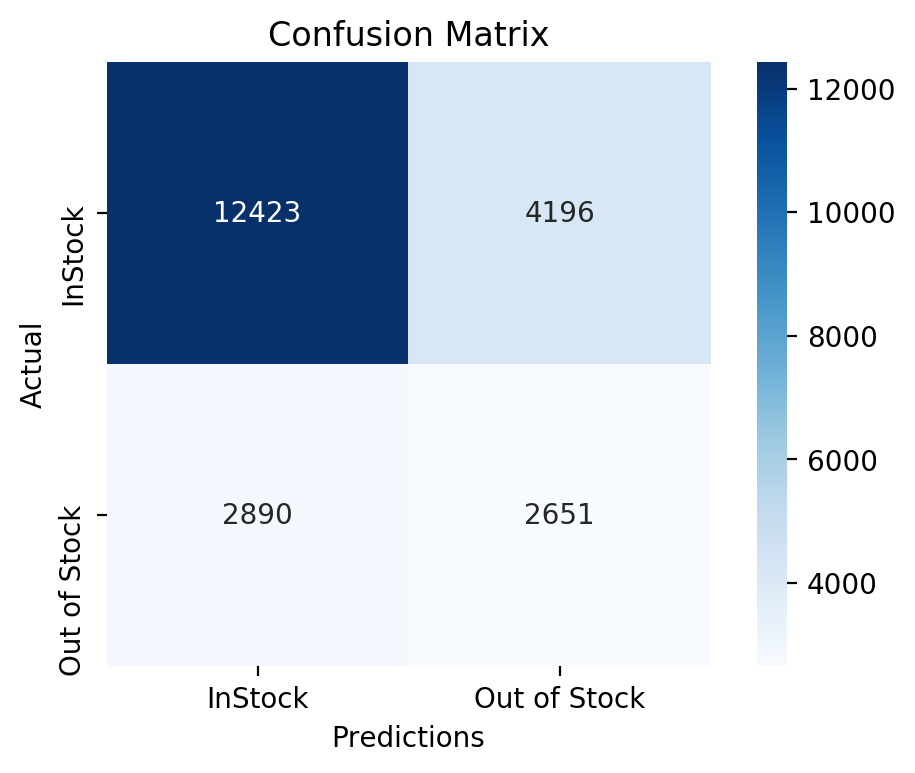

In [134]:
gb_confusion = confusion_matrix(y_test, gb.predict(X_te))
print_heatmap(gb_confusion)
print("Recall for OOS class:",recall(gb_confusion))

We see possibly more concern over the OOS class by using Gaussian NB since the data is Standardized. Although there is an increase in False Positive values which decreases the specificity of the model. Classifying Instock phenomenan as OOS can be tolerated upto some extent, since recommending OOS without any stockout in reality will result more piling up of inventory. This causes storage expenses. Hence Specificity metrics is also a concern while modeling. 

In [19]:
svc = SVC(kernel='rbf')
svc.fit(X_tr, y_train)
print("The score for Support Vector is")
print("Training: {:6.2f}%".format(100*svc.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*svc.score(X_te, y_test)))

The score for Support Vector is
Training:  75.00%
Test set:  75.00%


Recall: 0.06442880346507851


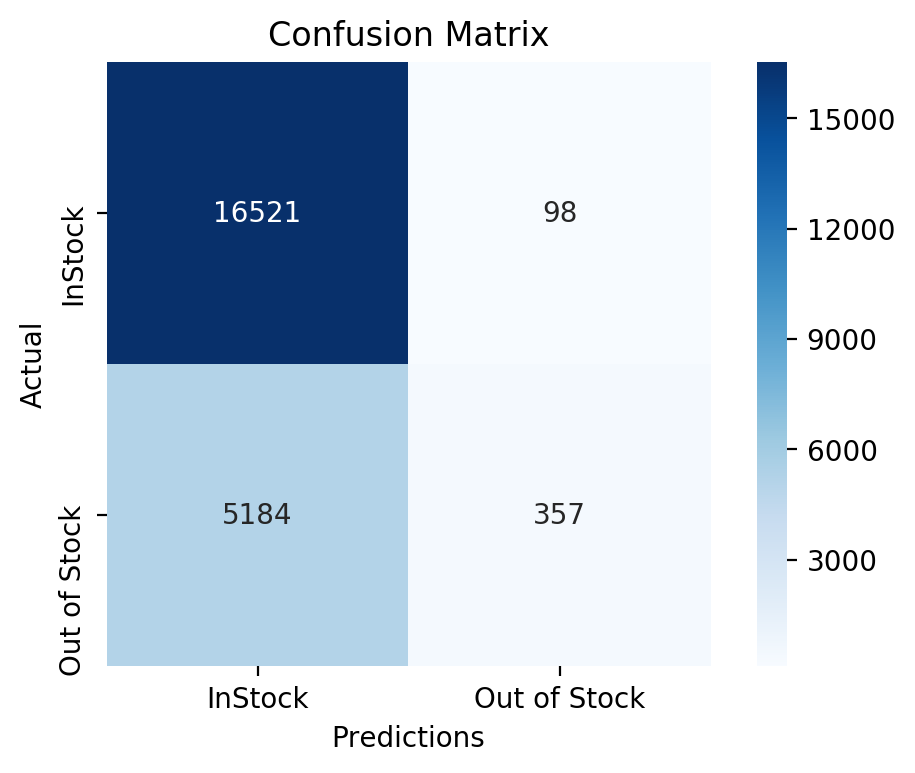

In [37]:
svc_confusion = confusion_matrix(y_test, svc.predict(X_te))
print_heatmap(svc_confusion)
print("Recall:",recall(svc_confusion))

Support Vectors fails terribly on Imbalanced Class using the radial basis kernel. This method is being rejected at cross validation level itself.

In [22]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_tr, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*rfc.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*rfc.score(X_te, y_test)))

The score for logistic regression is
Training:  99.22%
Test set:  90.52%


Recall: 0.8002165674066053


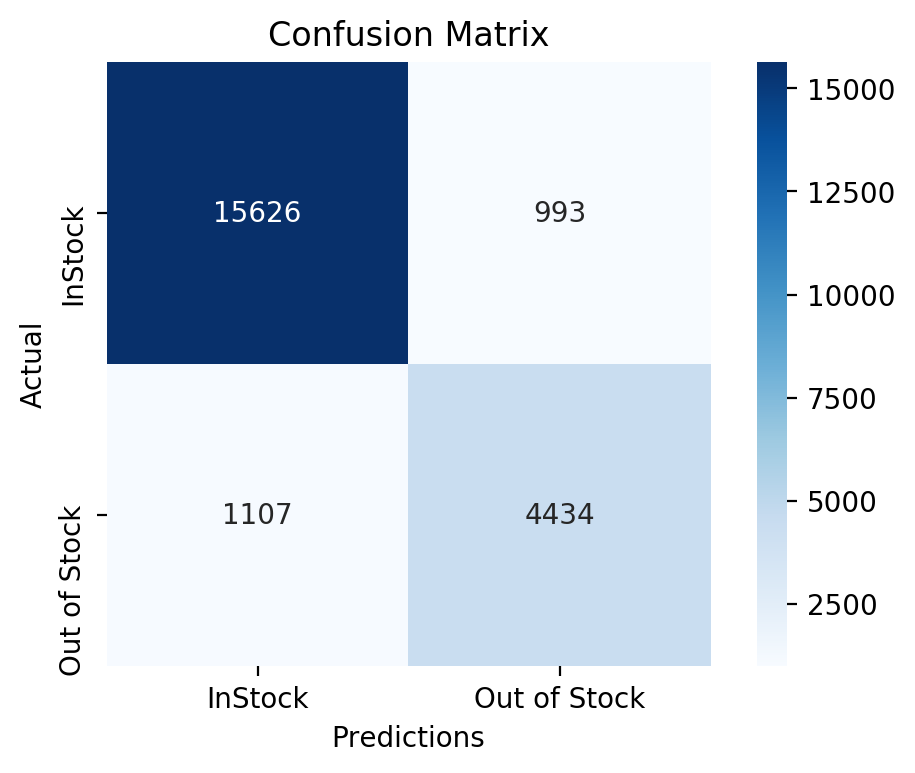

In [23]:
rfc_confusion = confusion_matrix(y_test, rfc.predict(X_te))
print_heatmap(rfc_confusion)
print("Recall:",recall(rfc_confusion))

 As we can see, an Ensemble model has performed better on Sensitivity score (Recall) and more number of units are being identified as Out of Stock inspite of imbalance classes.Hence evaluating this model on the entire train dataset.

#### Scoring

In [24]:
def make_confusion_matrix(model, threshold, X, y):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X)[:, 1] >= threshold)
    return confusion_matrix(y, y_predict) 

#Score for a given threshold
def min_threshold(model, threshold, X, y):
    y_predict = (model.predict_proba(X)[:, 1]>= threshold)
    return min(precision_score(y, y_predict), recall_score(y, y_predict))

#f1 score for a given threshold
def f1_threshold(model, threshold, X, y):
    y_predict = (model.predict_proba(X)[:, 1]>= threshold)
    return f1_score(y, y_predict)

Find threshold to maximize the score. Use train set, then maximize threshold on test set.

In [25]:
def max_score(model, X, y):
    threshold = -1
    score = 0
    for i in np.linspace(0,.6,1001):
        temp = min_threshold(model, i, X, y)
        if temp > threshold:
            threshold = temp
            score = i
    return [threshold,score]

Find max f1 threshold to maximize score. Use train set, then maximize threshold on test set.

In [26]:
def max_f1(model, X, y):
    threshold = -1
    score = 0
    for i in np.linspace(0,.6,1001):
        temp = f1_threshold(model, i, X, y)
        if temp > threshold:
            threshold = temp
            score = i
    return [threshold,score]

In [27]:
def print_score(model, X, y):
    print(f"The max score for {type(model).__name__} is")
    maxscore = max_score(model, X, y)
    print("Test set: {:6.2f}% ".format(100*maxscore[0]) + "at a threshold of {:.3f}".format(maxscore[1]))

In [28]:
def print_f1(model, X, y):
    print(f"The max score for {type(model).__name__} is")
    maxscore = max_f1(model, X, y)
    print("Test set: {:6.2f}% ".format(100*maxscore[0]) + "at a threshold of {:.3f}".format(maxscore[1]))

### Baseline Models

In [135]:
print_f1(logit, X_te, y_test)

The max score for LogisticRegression is
Test set:  47.81% at a threshold of 0.215


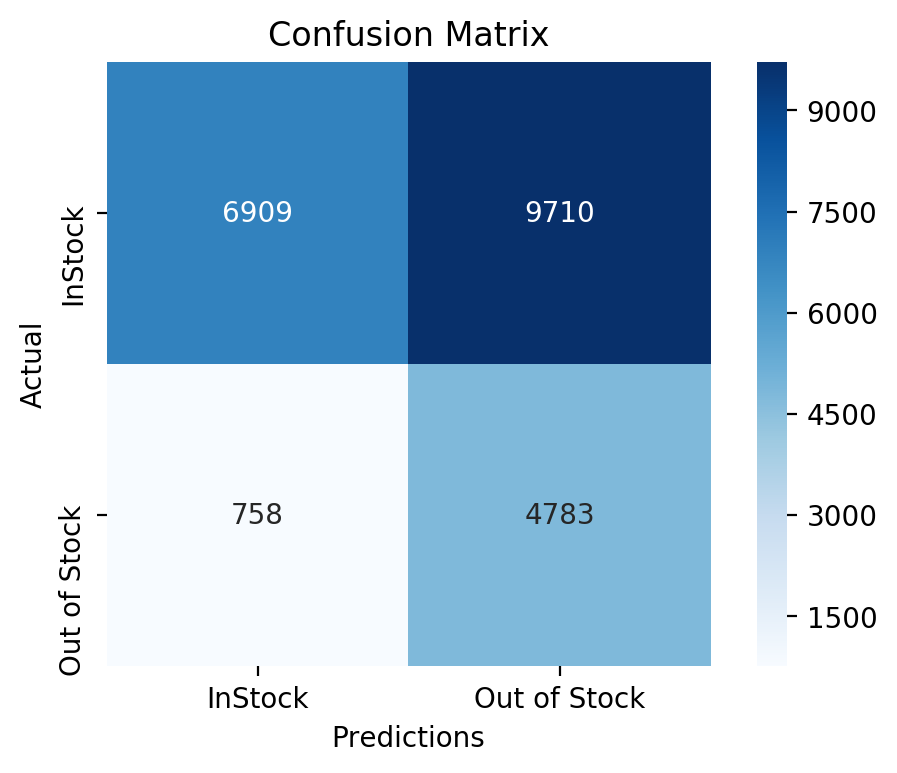

In [137]:
logit_confusion2 = make_confusion_matrix(logit, .215, X_te, y_test)
print_heatmap(logit_confusion2)

In [138]:
print("Sensitivity: ",recall(logit_confusion2))
print("Specificity: ",6909/(6909+9710))

Sensitivity:  0.8632015881609818
Specificity:  0.4157289848968049


In [139]:
print_f1(gb, X_te, y_test)

The max score for GaussianNB is
Test set:  40.07% at a threshold of 0.472


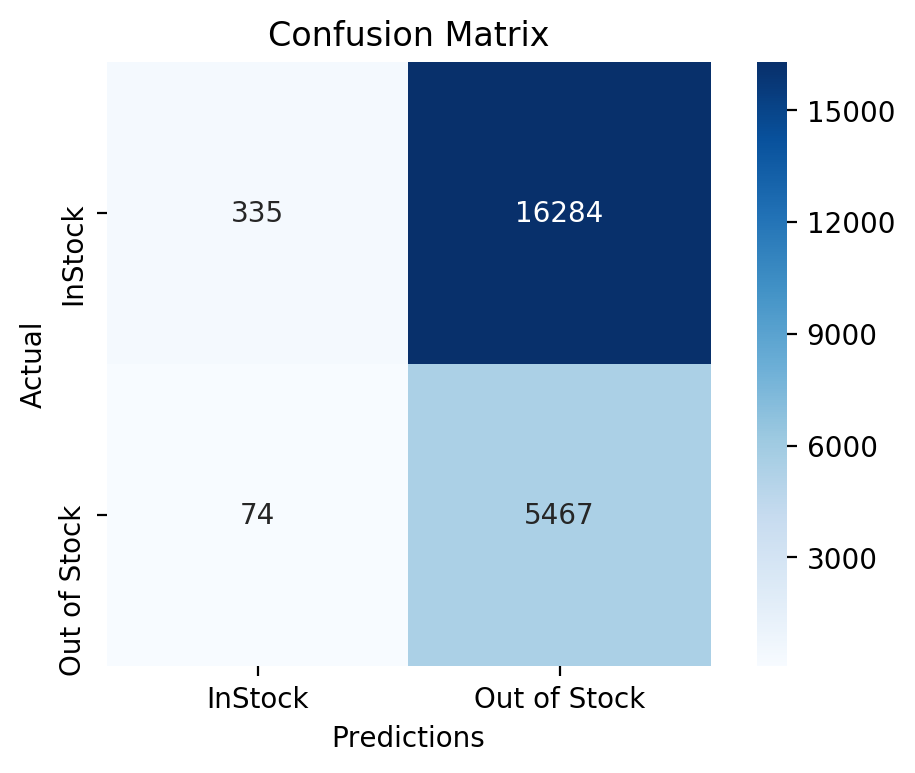

In [141]:
gb2_confusion2 = make_confusion_matrix(gb, .472, X_te, y_test)
print_heatmap(gb2_confusion2)

In [142]:
print("Sensitivity: ",recall(gb2_confusion2))
print("Specificity: ",335/(335+16284))

Sensitivity:  0.9866450099260061
Specificity:  0.02015765088152115


<comment

### Feature Selection

First we tried using Recursive Feature Elimination to find features, but we would ultimately be able to get a better test prediction manually selecting features (based off OLS and Lasso), so we would abandon RFE.

In [144]:
print("No of Predictive Features:",X_train.shape[1])

No of Predictive Features: 16


In [145]:
from sklearn.feature_selection import RFE

rfe_selector = RFE(estimator=LogisticRegression(solver='lbfgs',C=10.5), n_features_to_select=10, step=20, verbose=5)
rfe_selector.fit(X_tr, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 16 features.


C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


10 selected features


In [146]:
rfe_feature

['national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'sales_1_month',
 'min_bank',
 'potential_issue',
 'deck_risk',
 'ppap_risk',
 'stop_auto_buy']

In [147]:
under_sample_train_df.columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'sales_1_month', 'sales_3_month', 'min_bank', 'potential_issue',
       'pieces_past_due', 'perf_6_month_avg', 'local_bo_qty', 'deck_risk',
       'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop',
       'went_on_backorder'],
      dtype='object')

In [148]:
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

 Patsy introduction for OLS and Lasso Analysis

In [149]:
yXstring = 'went_on_backorder ~ national_inv+lead_time+in_transit_qty+forecast_3_month+sales_1_month+sales_3_month+min_bank+potential_issue+pieces_past_due+perf_6_month_avg+local_bo_qty+deck_risk+oe_constraint+ppap_risk+stop_auto_buy+rev_stop'
y, X = patsy.dmatrices(yXstring, data=under_sample_train_df, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      went_on_backorder   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     143.8
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        19:43:23   Log-Likelihood:                -31113.
No. Observations:               55400   AIC:                         6.226e+04
Df Residuals:                   55383   BIC:                         6.241e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4917      0.007     75.532      0.000       0.479       0.504
national_inv     -1.764e-06   3.74e-07     -4.717      0.000    -2.5e-06   -1.03e-06
lead_time           -0.0068      0.000    -22.546      0.000      -0.007      -0.006
in_transit_qty   -3.006e-05   5.05e-06     -5.949      0.000      -4e-05   -2.02e-05
forecast_3_month  8.856e-06   1.44e-06      6.159      0.000    6.04e-06    1.17e-05
sales_1_month     1.028e-05   4.35e-06      2.364      0.018    1.75e-06    1.88e-05
sales_3_month    -3.077e-07   4.03e-07     -0.763      0.445    -1.1e-06    4.82e-07
min_bank          -3.73e-05   7.28e-06     -5.125      0.000   -5.16e-05    -2.3e-05
potential_issue      0.3829      0.048      7.998      0.000       0.289       0.477
pieces_past_due   7.764e-05   1.89e-05      4.098      0.000    4.05e-05       0.000
perf_6_month_avg    -0.2362      0.007    -31.958      0.000      -0.251      -0.222
local_bo_qty         0.0004   4.34e-05      8.341      0.000       0.000       0.000
deck_risk           -0.0844      0.005    -18.718      0.000      -0.093      -0.076
oe_constraint        0.1276      0.103      1.239      0.216      -0.074       0.330
ppap_risk            0.0438      0.005      8.062      0.000       0.033       0.054
stop_auto_buy        0.0647      0.010      6.611      0.000       0.046       0.084
rev_stop            -0.0787      0.106     -0.740      0.459      -0.287       0.130
==============================================================================
Omnibus:                     9326.421   Durbin-Watson:                   0.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11844.821
Skew:                           1.091   Prob(JB):                         0.00
Kurtosis:                       2.392   Cond. No.                     3.81e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's see if our model is improving by dropping collinear columns

In [249]:
drop_cols = ['forecast_3_month','forecast_9_month','sales_3_month',
             'sales_9_month','perf_12_month_avg']
drop_df = under_sample_train_df.drop(columns=drop_cols)
y = drop_df['went_on_backorder']
X = drop_df.drop('went_on_backorder',axis=1)

In [250]:
X_tr, X_te, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [254]:
logit = LogisticRegression(solver = 'lbfgs')
logit.fit(X_tr, y_train)
print_f1(logit, X_te, y_test)

C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The max score for LogisticRegression is
Test set:  56.40% at a threshold of 0.289


In [255]:
nb = BernoulliNB()
nb.fit(X_tr, y_train)
print_f1(nb, X_te, y_test)

The max score for BernoulliNB is
Test set:  55.34% at a threshold of 0.267


Our model improved significantly by dropping collinear columns!

Removing these columns actually improved the logistic regression by a slight amount, while Naive Bayes was predictably unaffected.

In [150]:
logit_all = LogisticRegression(solver = 'lbfgs',C=10.5)
logit_all.fit(X_tr, y_train)
print_f1(logit_all, X_te, y_test)

C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The max score for LogisticRegression is
Test set:  47.81% at a threshold of 0.215


In [151]:
coefs = pd.DataFrame(list(zip(X_train.columns,list(logit_all.coef_[0]))))

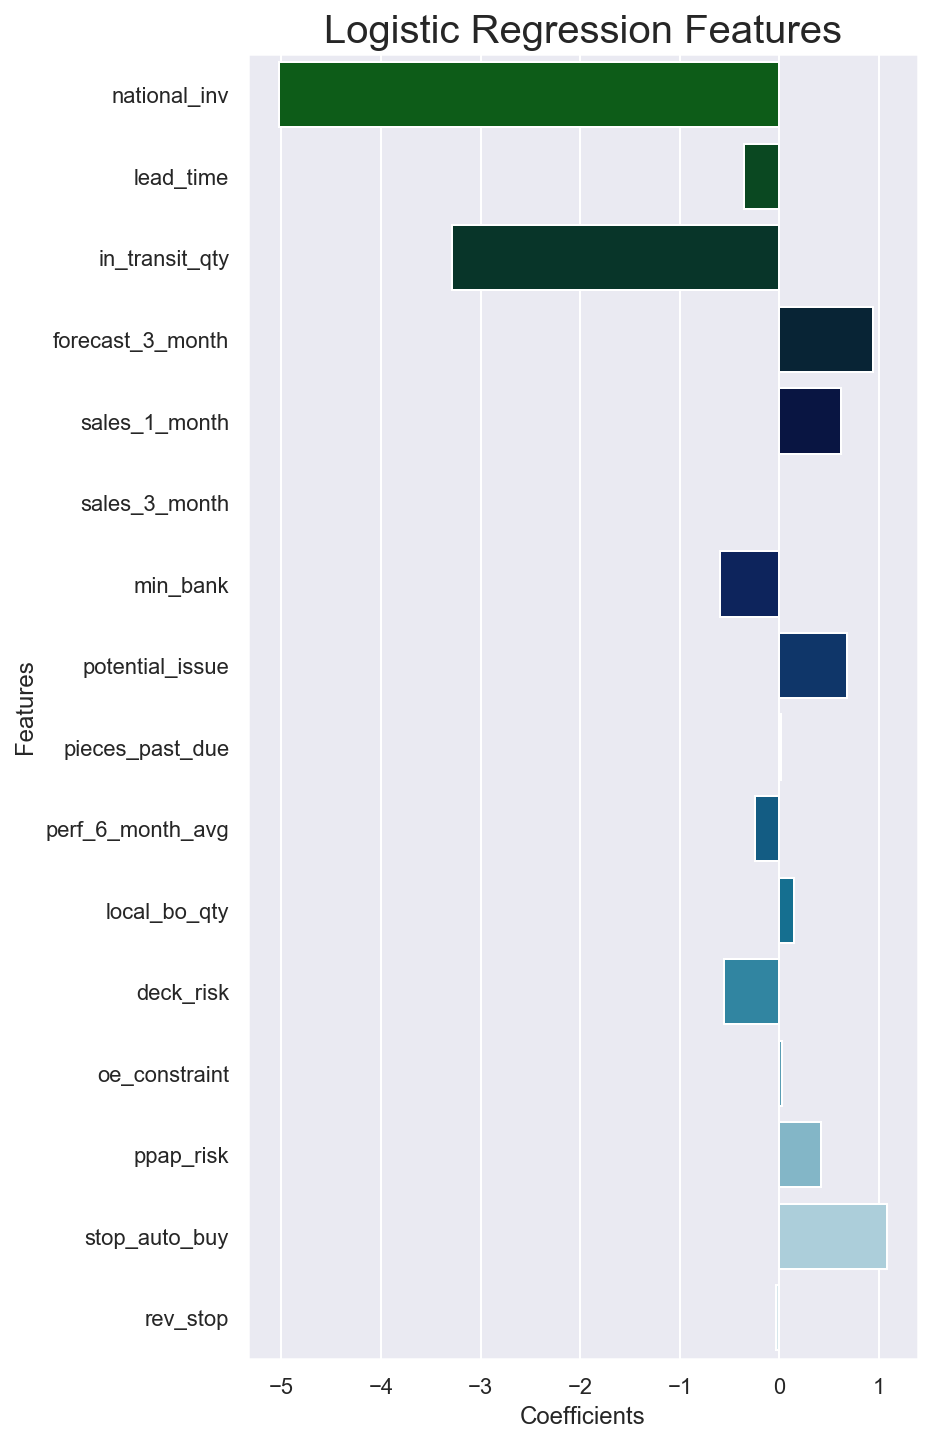

In [242]:
fig = plt.figure(figsize=(6,12))
sns.set(font_scale = 1)
ax = sns.barplot(x = coefs[1], y=coefs[0], palette = 'ocean');
plt.title("Logistic Regression Features", fontsize=20)
ax.set(ylabel='Features', xlabel = 'Coefficients');

In [156]:
cols = ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'sales_1_month', 'min_bank', 'potential_issue',
       'perf_6_month_avg', 'local_bo_qty', 'deck_risk',
        'ppap_risk', 'stop_auto_buy']

In [252]:
logit_final = LogisticRegression(solver = 'lbfgs',C=10.5)
logit_final.fit(X_tr[cols], y_train)
print_f1(logit_final, X_te[cols], y_test)

The max score for LogisticRegression is
Test set:  53.56% at a threshold of 0.245


 As we can see perfomance has increased

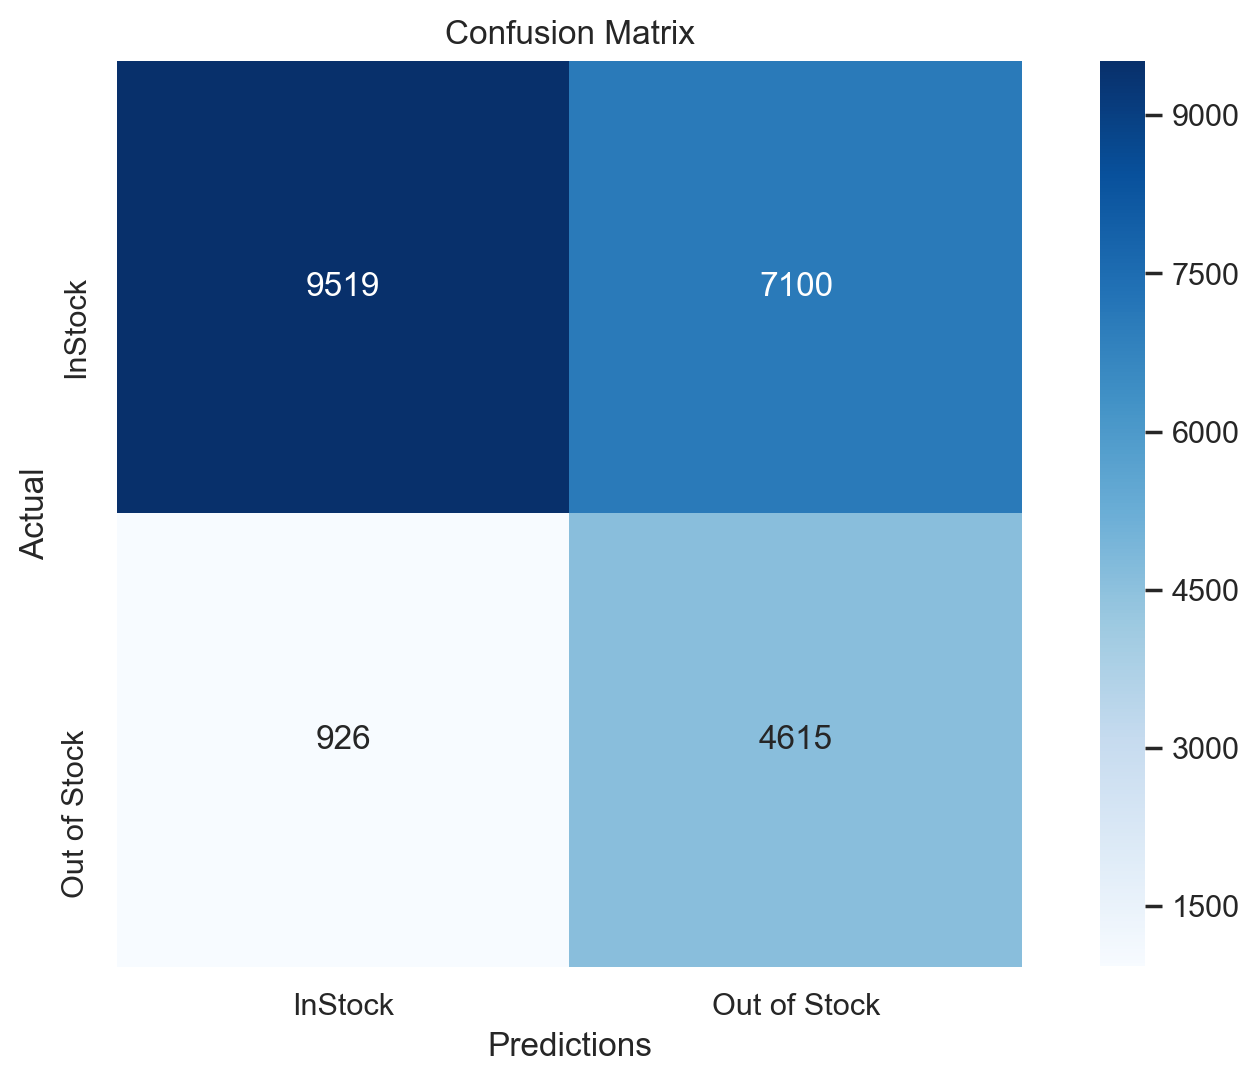

In [253]:
logit_confusion = make_confusion_matrix(logit_final, .245, X_te[cols], y_test)
print_heatmap(logit_confusion)

In [161]:
# Thats the best perfomance of logistic regression

In [185]:
pickle_out = open("logit_final.pkl","wb")
pickle.dump(logit_final, pickle_out)
pickle_out.close()

## Primary Models
### Grid Search
###                           
#### 1) Random Forest

In [162]:
from sklearn.model_selection import GridSearchCV

In [165]:
param_grid = {
    'bootstrap': [True],
    'max_features': [3,7,10],
    'min_samples_leaf': [2,3,5],
    'n_estimators': [100,120,150]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

In [166]:
grid_search.fit(X_tr, y_train)
grid_search.best_params_

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 12.3min finished


{'bootstrap': True,
 'max_features': 7,
 'min_samples_leaf': 2,
 'n_estimators': 120}

In [167]:
rf_all = RandomForestClassifier(bootstrap = True,
 max_features = 7,
 min_samples_leaf= 2,
 n_estimators= 120)

In [168]:
rf_all.fit(X_tr, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [169]:
rf_all.fit(X_tr, y_train)
print_f1(rf_all, X_te, y_test)

The max score for RandomForestClassifier is
Test set:  80.87% at a threshold of 0.392


Sensitivity: 0.8467785598267461
Specificity: 0.9175040616162224
FPR: 0.0824959383837776
TPR: 0.8467785598267461
Precision: 0.7738743196437408


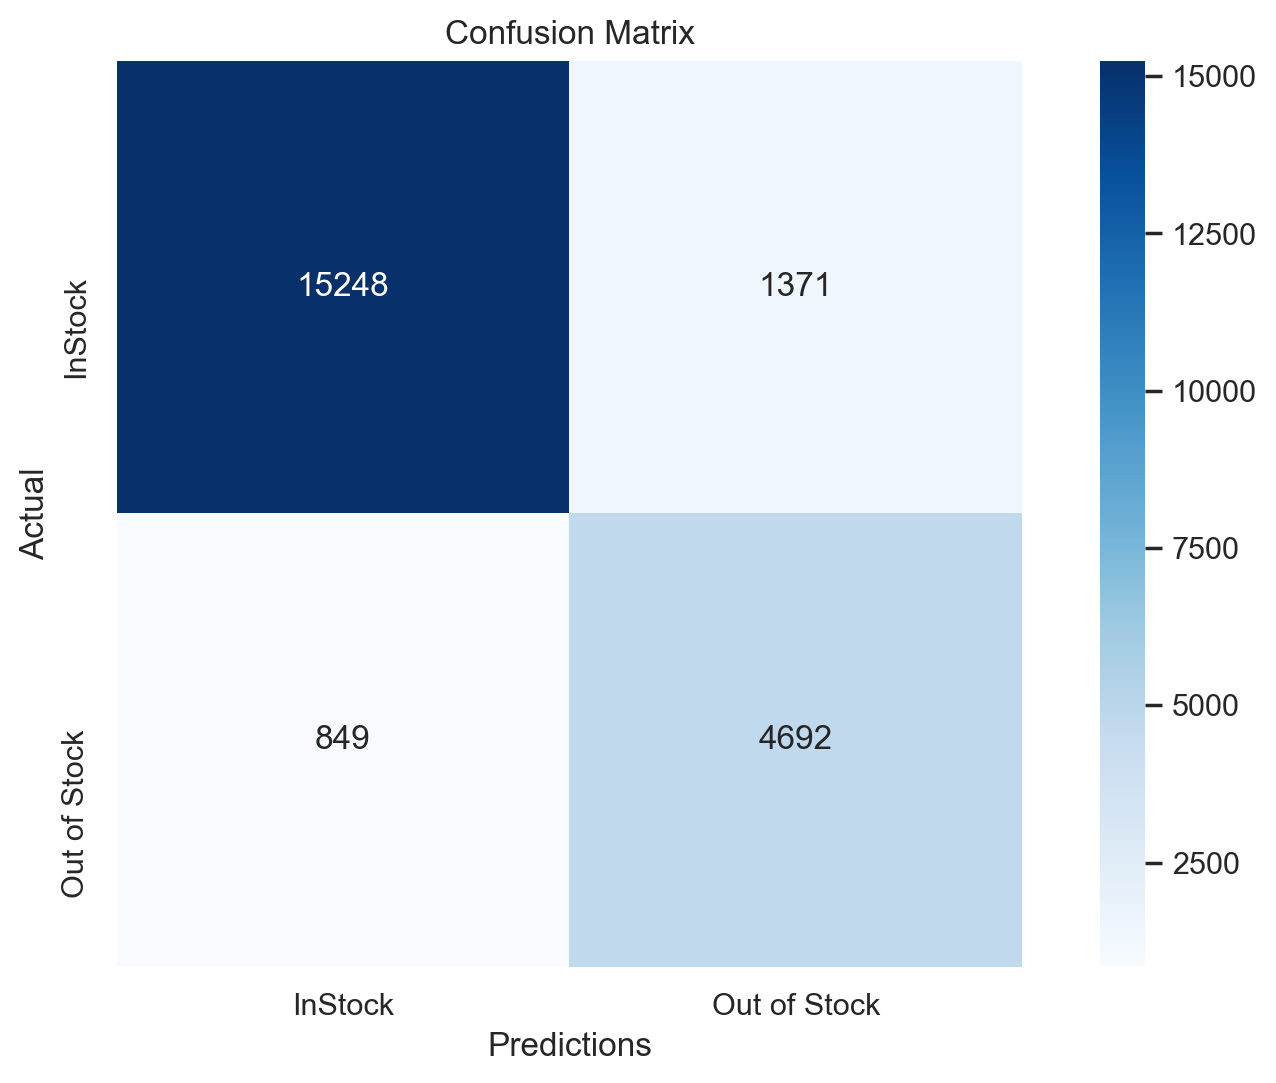

In [254]:
rf_confusion = make_confusion_matrix(rf_all, .392, X_te, y_test)
print_heatmap(rf_confusion)
print("Sensitivity:",recall(rf_confusion))
print("Specificity:",15248/(1371+15248))
print("FPR:",1371/(1371+15248))
print("TPR:",4692/(4692+849))
print("Precision:",precision(rf_confusion))

In [172]:
# Comments

In [173]:
t,s=max_score(rf_all, X_te, y_test)

In [174]:
print("Max Score:",t,"|","Optimal Threshold:",s)

Max Score: 0.8036455513445226 | Optimal Threshold: 0.4644


In [177]:
feature_imp = rf_all.feature_importances_

In [178]:
fr = pd.DataFrame()

In [179]:
fr['Importance']=feature_imp
fr['Feature']=X_tr.columns

In [180]:
fr = fr.sort_values(by=['Importance'],ascending=False)

In [181]:
fr = fr.reset_index().drop('index',axis=1)

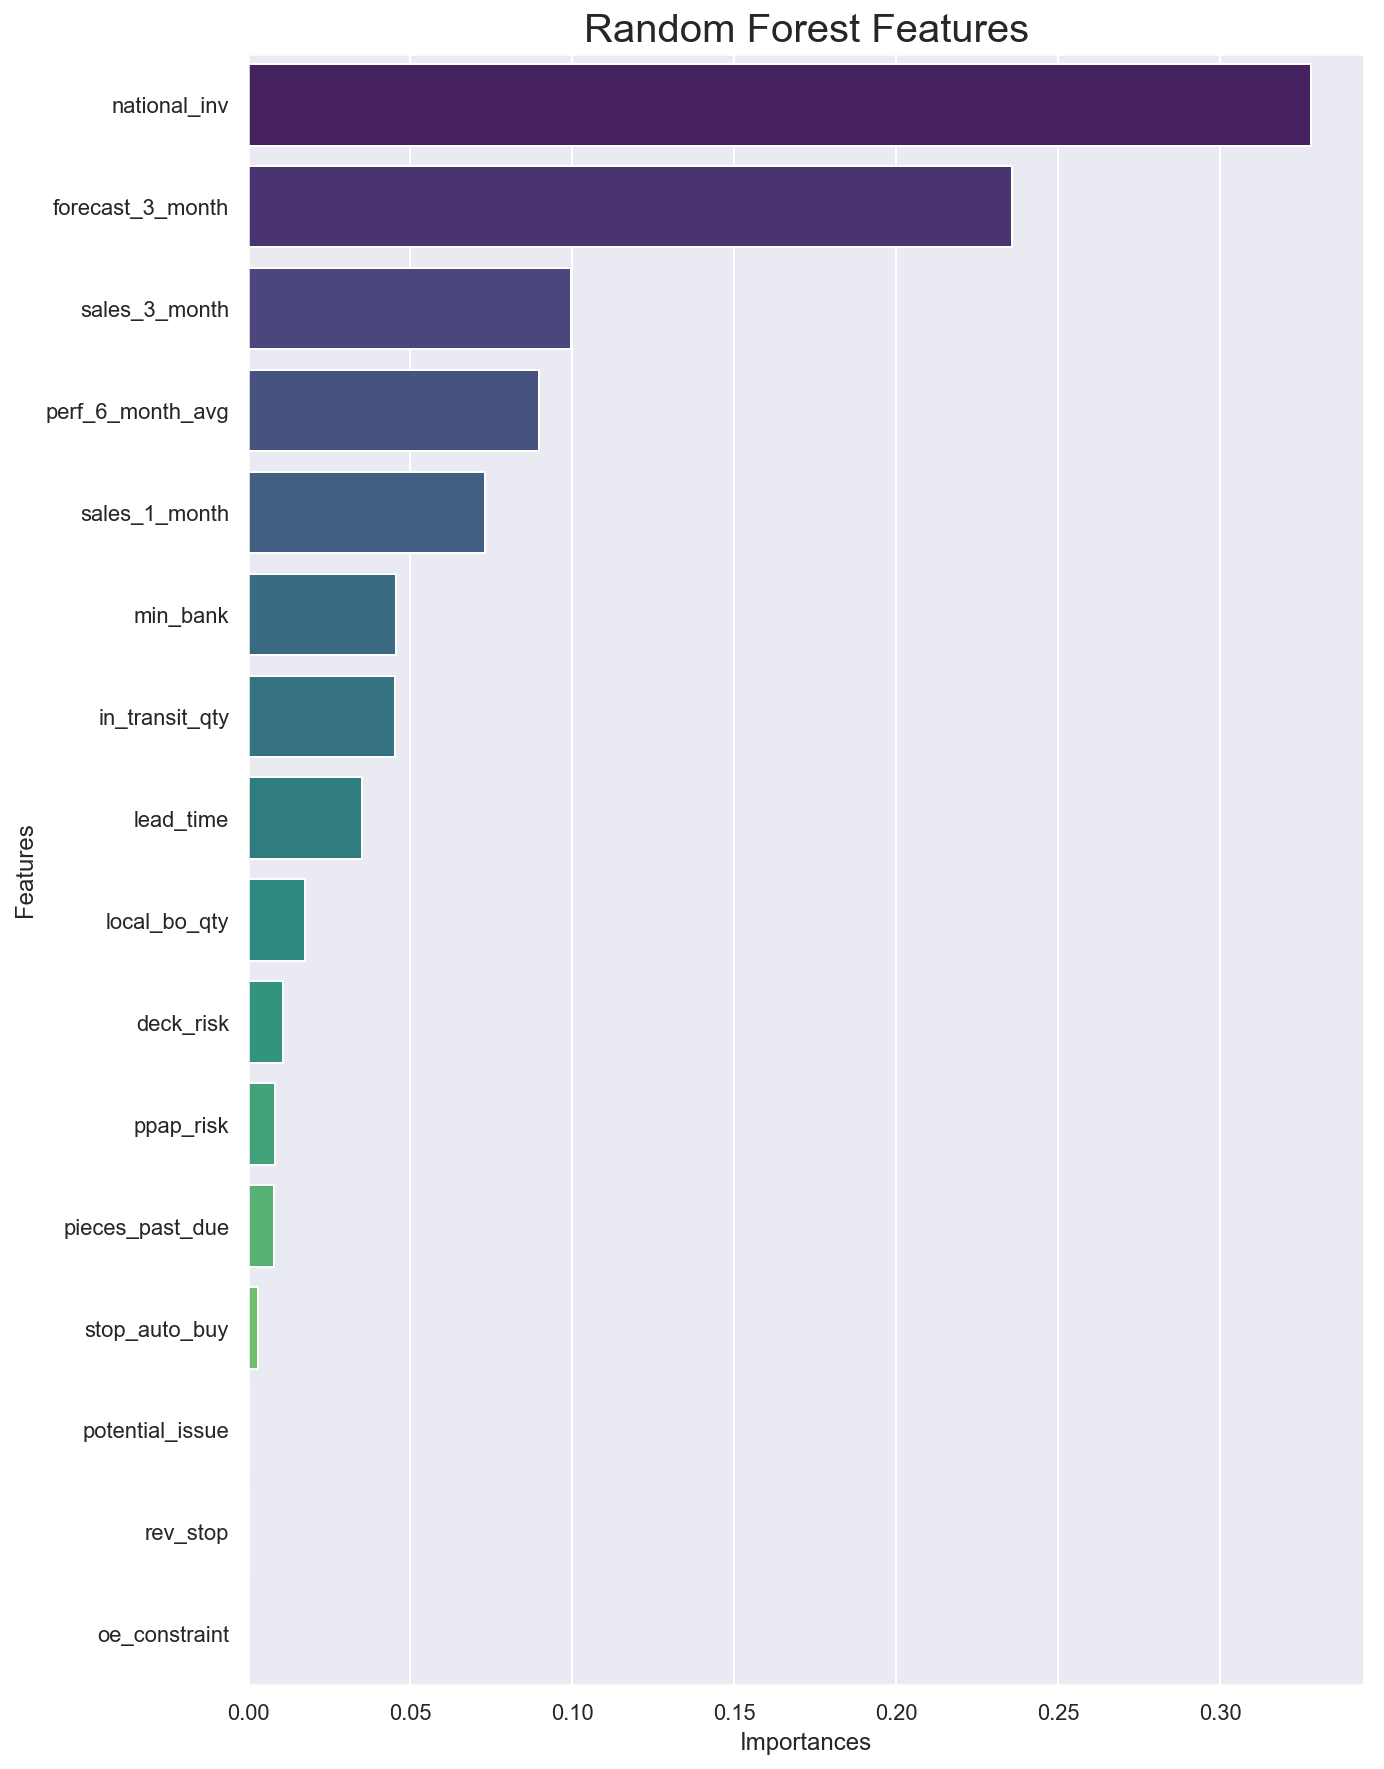

In [244]:
fig = plt.figure(figsize=(10,15))
sns.set(font_scale = 1)
ax = sns.barplot(x = fr['Importance'], y=fr['Feature'], palette = 'viridis');
plt.title("Random Forest Features", fontsize=20)
ax.set(ylabel='Features', xlabel = 'Importances');

In [245]:
fig.savefig('rfc_feat.png')

In [183]:
# We also see the importance of features

Hence we can see that Random Forest is quite an improvement over Logistic Regression

In [184]:
pickle_out = open("rf_all.pkl","wb")
pickle.dump(rf_all, pickle_out)
pickle_out.close()

### 2) XGBOOST

In [190]:
xgb = XGBClassifier()
xgb.fit(X_tr, y_train);
print_f1(xgb, X_te, y_test)

The max score for XGBClassifier is
Test set:  78.10% at a threshold of 0.420


XGB is performing brilliantly inspite of any GridSearch

In [191]:
param_grid = {
    'learning_rate': [ 0.06,0.1,0.5],
    'subsample': [.75],
    'max_depth': [6,8,10],
    'colsample_bytree': [ .9,0.95],
    'gamma': [1]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

In [192]:
grid_search.fit(X_tr, y_train)
grid_search.best_params_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  9.3min finished


{'colsample_bytree': 0.95,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 10,
 'subsample': 0.75}

In [193]:
xgb = XGBClassifier(colsample_bytree = 0.95, gamma=1, learning_rate=.1, max_depth=10, subsample=0.75)
xgb.fit(X_tr, y_train);

In [194]:
print_f1(xgb, X_te, y_test)

The max score for XGBClassifier is
Test set:  80.43% at a threshold of 0.335


Sensitivity: 0.8547193647356073
Specificity: 0.9097418617245322
FPR: 0.09025813827546784
TPR: 0.8547193647356073
Precision: 0.7594611930724824


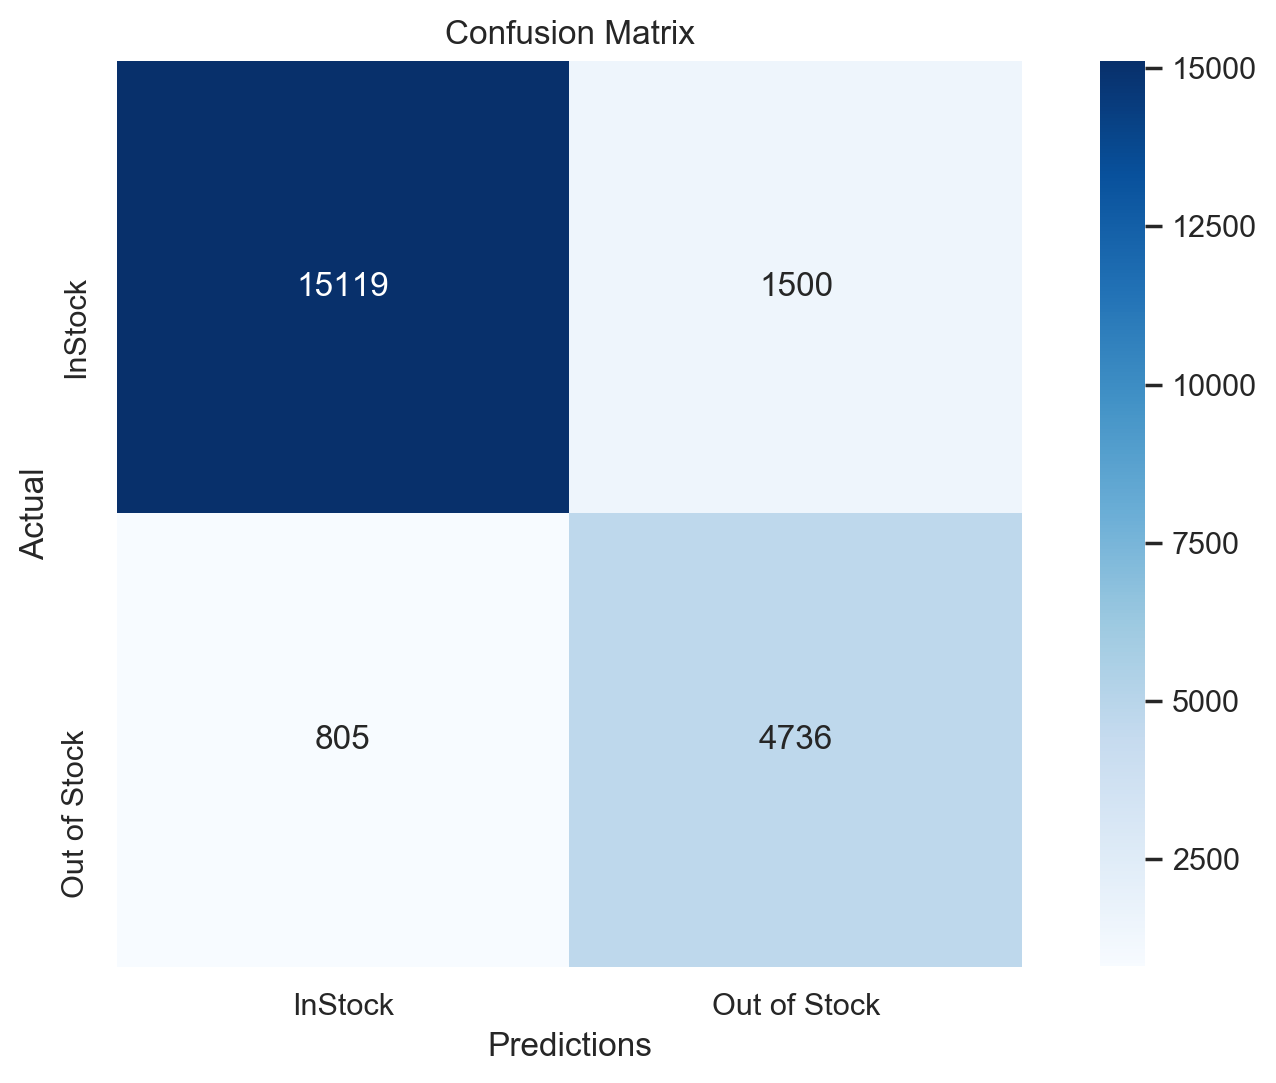

In [255]:
xgb_confusion = make_confusion_matrix(xgb, .335, X_te, y_test)
print_heatmap(xgb_confusion)
print("Sensitivity:",recall(xgb_confusion))
print("Specificity:",15119/(1500+15119))
print("FPR:",1500/(1500+15119))
print("TPR:",4736/(4736+805))
print("Precision:",precision(xgb_confusion))

In [197]:
t,s=max_score(xgb, X_te, y_test)

In [198]:
print("Max Score:",t,"|","Optimal Threshold:",s)

Max Score: 0.7977629442540141 | Optimal Threshold: 0.4608


In [199]:
pickle.dump(xgb,open("xgb.pkl","wb"))

We can see excellent results on both Sensitivity and Specificity. We can also see reduction in the False Negative and False Postivie cells of the confusion Matrix meaning our predictions (either in stock or OOS) are more reliable

## 3)Naive Bayes

In [201]:
gb_all = GaussianNB(var_smoothing=0.1510513)
gb_all.fit(X_tr,y_train)
print_f1(gb_all, X_te, y_test)

The max score for GaussianNB is
Test set:  40.07% at a threshold of 0.472


Sensitivity: 0.9866450099260061
Specificity: 0.02015765088152115
FPR: 0.9798423491184789
TPR: 0.9866450099260061
Precision: 0.2513447657578962


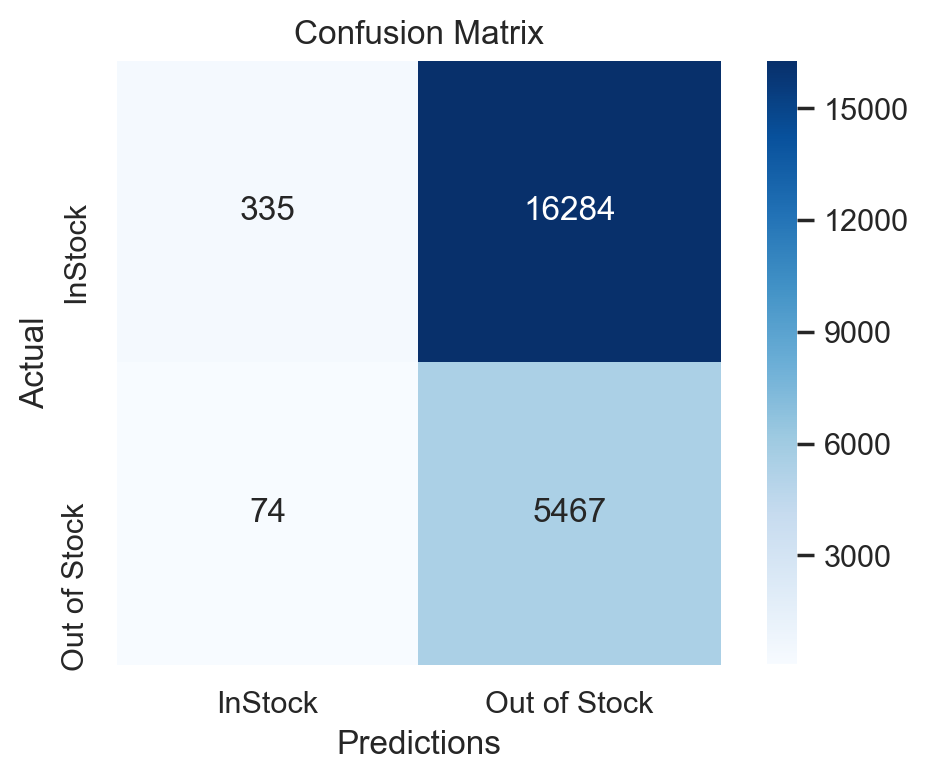

In [203]:
gb_all_confusion = make_confusion_matrix(gb_all,0.472 , X_te, y_test)
print_heatmap(gb_all_confusion)
print("Sensitivity:",recall(gb_all_confusion))
print("Specificity:",335/(335+16284))
print("FPR:",16284/(335+16284))
print("TPR:",5467/(5467+74))
print("Precision:",precision(gb_all_confusion))

Gaussian Naive Bayes fails terribly on Specificity

### 4)Decision Trees

In [205]:
dt = DecisionTreeClassifier()
dt.fit(X_tr, y_train);
print_f1(dt, X_te, y_test)

The max score for DecisionTreeClassifier is
Test set:  74.62% at a threshold of 0.400


In [206]:
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth': [4,5,7,10,20,30,50,75,100],
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dt, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

In [207]:
grid_search.fit(X_tr, y_train)
grid_search.best_params_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   18.5s finished


{'criterion': 'entropy', 'max_depth': 10}

In [209]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=10)
dt.fit(X_tr, y_train);
print_f1(dt, X_te, y_test)

The max score for DecisionTreeClassifier is
Test set:  77.55% at a threshold of 0.353


Sensitivity: 0.8267460747157552
Specificity: 0.8981888200252722
FPR: 0.10181117997472772
TPR: 0.8267460747157552
Precision: 0.7302725968436155


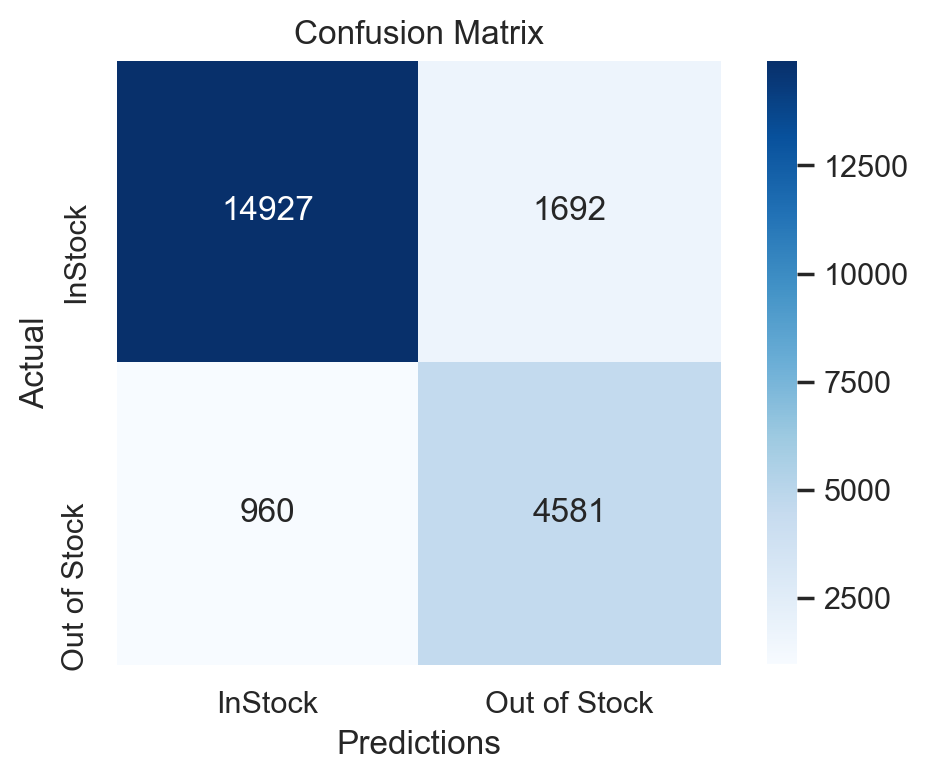

In [211]:
dt_confusion = make_confusion_matrix(dt,0.353 , X_te, y_test)
print_heatmap(dt_confusion)
print("Sensitivity:",recall(dt_confusion))
print("Specificity:",14927/(14927+1692))
print("FPR:",1692/(1692+14927))
print("TPR:",4581/(4581+960))
print("Precision:",precision(dt_confusion))

In [212]:
# Best tradeoff is being observed in Decision trees

Since our major focus was on Sensitivity and Specificity because of the kind of problem we are tackling, here we can say that there is a tie between Random Forest and XGBoost. However XGBoost can improved by futher narrow range of parameters on grid search.

Grid Search is not super helpful with logistic regression. I tried every permutation of LogisticRegression paramaters (L1, L2, Elastinet with different hyperparamaters), but the suggested paramters do worse on the test set. Also since SVM failed at the cross validation level itself, we did not proceed with it as well.
 
Hence the winner over here are XGBoost and Random Forest

In [358]:
#Perform Logistic regression also

### Precision/Recall and ROC Curves

Max Score: 0.7977629442540141 | Optimal Threshold: 0.4608


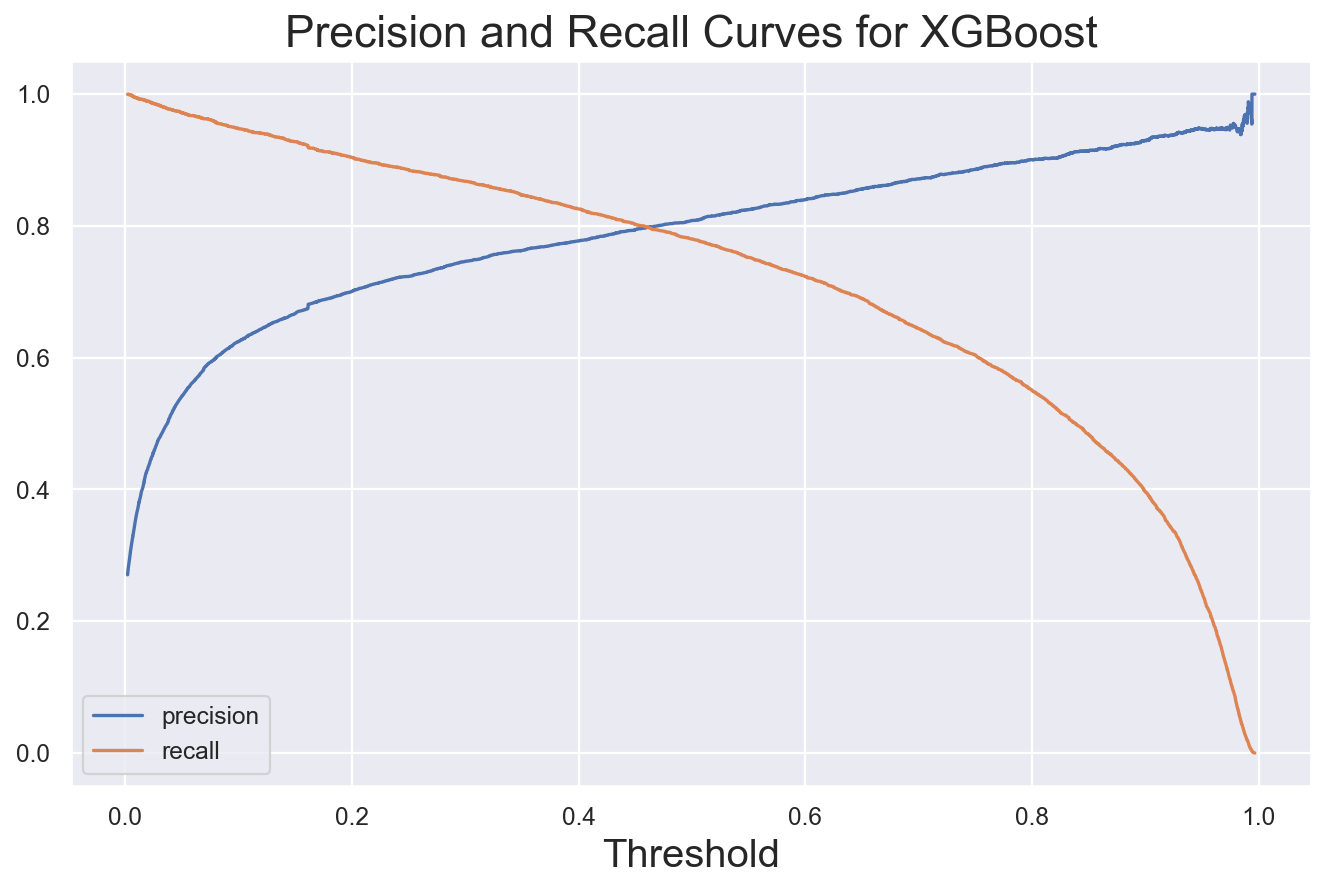

In [230]:
#XGBoost
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, xgb.predict_proba(X_te)[:,1] )
fig = plt.figure(dpi=80, figsize=(10,6))

plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold', fontsize=18);
plt.title('Precision and Recall Curves for XGBoost', fontsize=20);

t,s=max_score(xgb, X_te, y_test)
print("Max Score:",t,"|","Optimal Threshold:",s)


In [231]:
fig.savefig('xgb_PvR.png')

Max Score: 0.8036455513445226 | Optimal Threshold: 0.4644


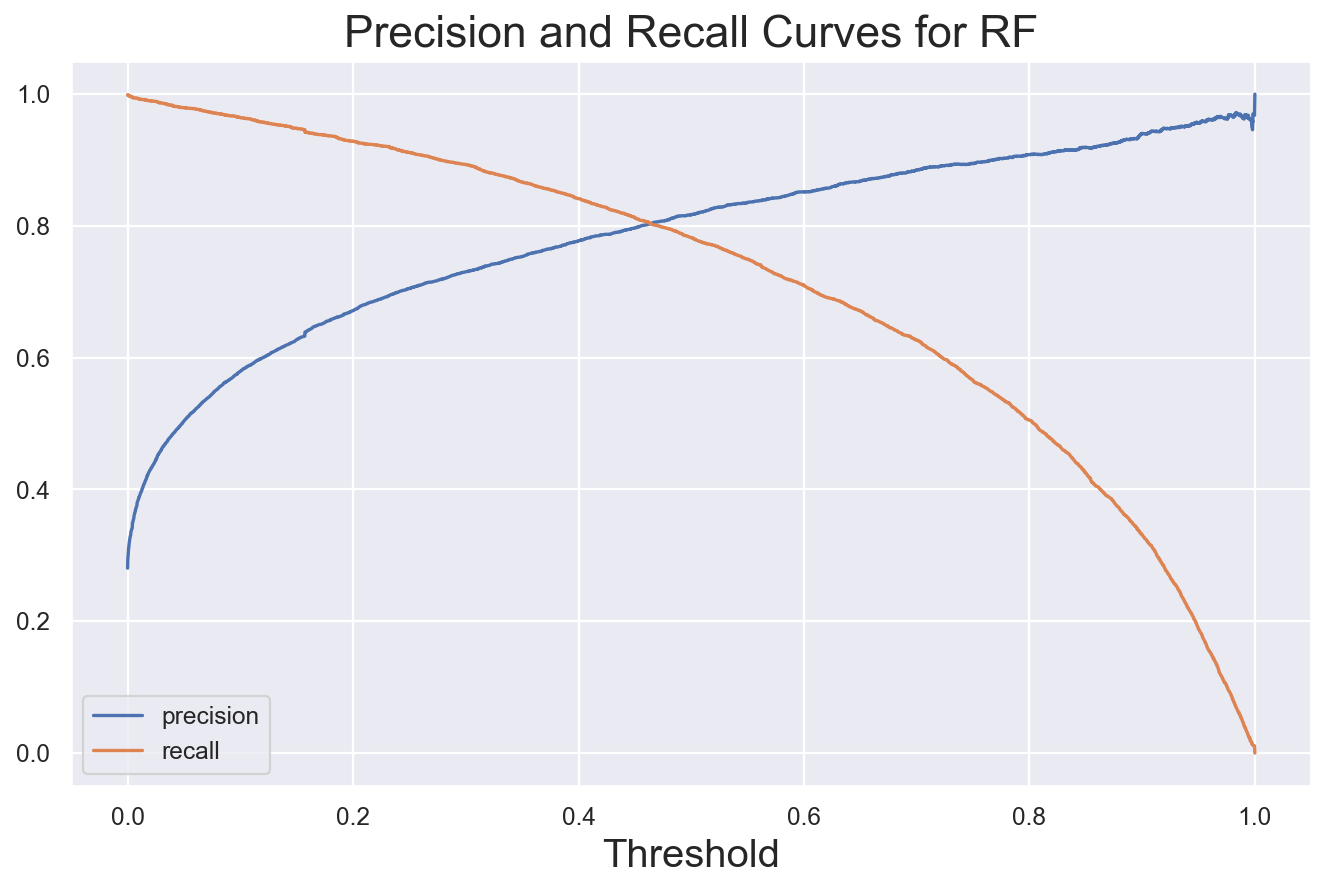

In [232]:
#Random Forest
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rf_all.predict_proba(X_te)[:,1] )
fig = plt.figure(dpi=80, figsize=(10,6))

plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold', fontsize=18);
plt.title('Precision and Recall Curves for RF', fontsize=20);

t,s=max_score(rf_all, X_te, y_test)
print("Max Score:",t,"|","Optimal Threshold:",s)

In [234]:
fig.savefig('rfc_PvR.png')

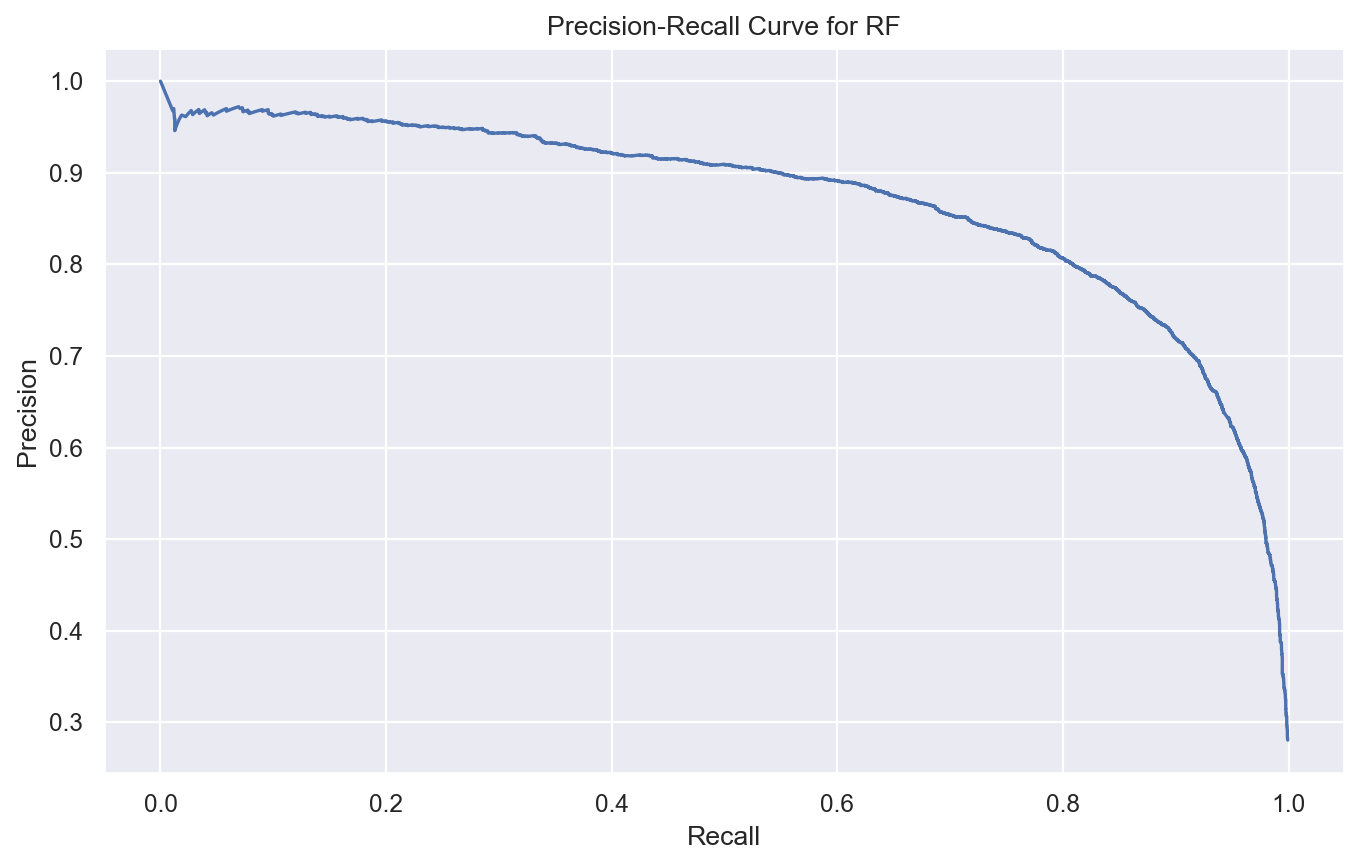

In [235]:
fig=plt.figure(dpi=80, figsize=(10,6))
plt.rcParams['figure.figsize'] = (10.0, 6)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for RF");

In [236]:
fig.savefig('PRcurve.png')

In [218]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics

In [241]:
def plot_AUC(X, y, model):
    fpr, tpr, thresh = metrics.roc_curve(y, model.predict_proba(X)[:,1])
    auc = metrics.roc_auc_score(y, model.predict_proba(X)[:,1])
    plt.figure(figsize=(16, 14))
    plt.plot(fpr,tpr,label=type(model).__name__)
    plt.plot([0,1],[0,1],ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend(loc=4);
    
    
    plt.xlabel('False positive rate', fontsize=18)
    plt.ylabel('True positive rate', fontsize=18)
    plt.title('ROC curve for Stockout Prediction', fontsize=22);
    print(type(model).__name__ + " ROC AUC score : {:f}".format(roc_auc_score(y, model.predict_proba(X)[:,1])))
    

<IPython.core.display.Javascript object>


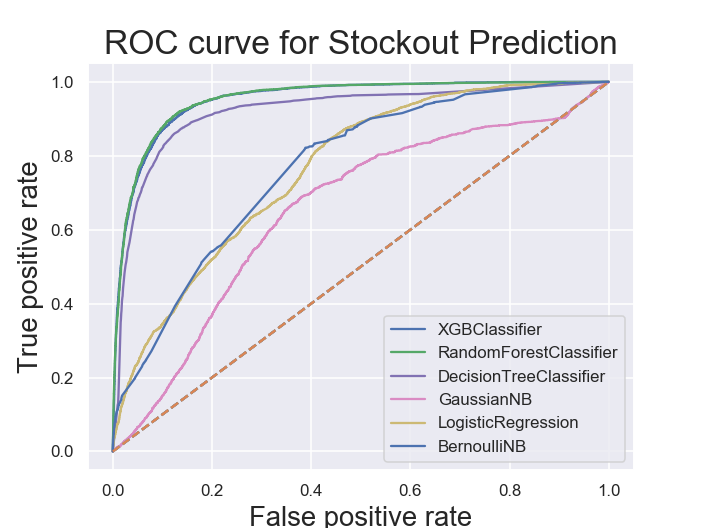

XGBClassifier ROC AUC score : 0.952092
RandomForestClassifier ROC AUC score : 0.953430
DecisionTreeClassifier ROC AUC score : 0.919720
GaussianNB ROC AUC score : 0.654640
LogisticRegression ROC AUC score : 0.765379
BernoulliNB ROC AUC score : 0.768038


In [258]:
plot_AUC(X_te, y_test, xgb)
plot_AUC(X_te, y_test, rf_all)
plot_AUC(X_te, y_test, dt)
plot_AUC(X_te, y_test,gb_all)
plot_AUC(X_te[cols], y_test,logit_final)
plot_AUC(X_te, y_test,nb)


In [19]:
# Saving desired models
#RFC And XGB
# Enter the below values for testing the deployment code

In [453]:
arr = np.array(X.loc[1913523])

In [456]:
X.loc[1913523]

national_inv         0.00
lead_time            2.00
in_transit_qty       0.00
forecast_3_month    27.00
sales_1_month        0.00
sales_3_month        0.00
min_bank             0.00
potential_issue      0.00
pieces_past_due      0.00
perf_6_month_avg     0.85
local_bo_qty         0.00
deck_risk            1.00
oe_constraint        0.00
ppap_risk            0.00
stop_auto_buy        0.00
rev_stop             0.00
Name: 1913523, dtype: float64